In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

''

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'image_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

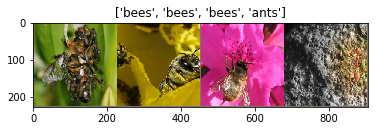

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
?next

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
import pretrainedmodels

In [9]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [11]:
basemodel = pretrainedmodels.__dict__['se_resnet50'](num_classes=1000, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth" to /Users/victor/.torch/models/se_resnet50-ce0d4300.pth
112611220it [05:17, 350334.09it/s]


In [31]:
from efficientnet_pytorch import EfficientNet
basemodel = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [11]:
?EfficientNet.from_pretrained

In [32]:
basemodel.parameters

<bound method Module.parameters of EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePa

In [33]:
num_ftrs = 1000
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
basemodel.last_linear = nn.Linear(num_ftrs, 2)

basemodel = basemodel.to(device)

In [34]:
from torchsummary import summary

In [35]:
summary(basemodel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
         ZeroPad2d-4         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
          Identity-7             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-8              [-1, 8, 1, 1]             264
          Identity-9              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 32, 1, 1]             288
         Identity-11         [-1, 32, 112, 112]               0
Conv2dStaticSamePadding-12         [-1, 16, 112, 112]             512
      BatchNorm2d-13         [-1, 16, 112, 112]              32
      MBConv

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(basemodel.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [39]:
basemodel = train_model(basemodel, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.7501 Acc: 0.5984
val Loss: 5.0215 Acc: 0.2941

Epoch 1/9
----------
train Loss: 1.1651 Acc: 0.5533
val Loss: 3.5500 Acc: 0.4248

Epoch 2/9
----------
train Loss: 0.9456 Acc: 0.6066
val Loss: 1.3019 Acc: 0.4575

Epoch 3/9
----------
train Loss: 0.9533 Acc: 0.6066
val Loss: 0.8314 Acc: 0.5621

Epoch 4/9
----------
train Loss: 1.0222 Acc: 0.5246
val Loss: 1.0825 Acc: 0.4837

Epoch 5/9
----------
train Loss: 1.0051 Acc: 0.5656
val Loss: 1.7942 Acc: 0.5882

Epoch 6/9
----------
train Loss: 0.8879 Acc: 0.6107
val Loss: 2.0238 Acc: 0.5229

Epoch 7/9
----------


Traceback (most recent call last):
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
   

KeyboardInterrupt: 

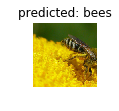

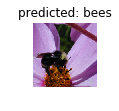

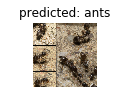

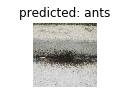

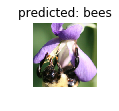

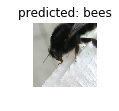

In [21]:
visualize_model(basemodel)

In [22]:
basemodel2 = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /Users/victor/.torch/models/se_resnext50_32x4d-a260b3a4.pth
110559176it [05:11, 355303.75it/s]


In [23]:
num_ftrs = basemodel2.last_linear.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
basemodel2.last_linear = nn.Linear(num_ftrs, 2)

basemodel2 = basemodel2.to(device)

In [24]:
summary(basemodel2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer_ft2 = optim.SGD(basemodel2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

In [28]:
basemodel2 = train_model(basemodel2, criterion, optimizer_ft2, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4489 Acc: 0.7828
val Loss: 0.1614 Acc: 0.9739

Epoch 1/9
----------
train Loss: 0.3269 Acc: 0.8566
val Loss: 0.2160 Acc: 0.9020

Epoch 2/9
----------
train Loss: 0.3453 Acc: 0.8279
val Loss: 0.1385 Acc: 0.9477

Epoch 3/9
----------
train Loss: 0.2498 Acc: 0.8811
val Loss: 0.1833 Acc: 0.9216

Epoch 4/9
----------
train Loss: 0.1767 Acc: 0.9221
val Loss: 0.1742 Acc: 0.9346

Epoch 5/9
----------
train Loss: 0.2119 Acc: 0.9016
val Loss: 0.1788 Acc: 0.9477

Epoch 6/9
----------
train Loss: 0.1481 Acc: 0.9344
val Loss: 0.1366 Acc: 0.9477

Epoch 7/9
----------
train Loss: 0.1631 Acc: 0.9467
val Loss: 0.1873 Acc: 0.9281

Epoch 8/9
----------
train Loss: 0.1322 Acc: 0.9508
val Loss: 0.1816 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.1130 Acc: 0.9508
val Loss: 0.1689 Acc: 0.9412

Training complete in 66m 52s
Best val Acc: 0.973856


In [29]:
basemodel3 = pretrainedmodels.__dict__['senet154'](num_classes=1000, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth" to /Users/victor/.torch/models/senet154-c7b49a05.pth
461488402it [35:40, 215633.78it/s]


In [30]:
num_ftrs = basemodel3.last_linear.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
basemodel3.last_linear = nn.Linear(num_ftrs, 2)

basemodel3 = basemodel3.to(device)

In [31]:
summary(basemodel3, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,864
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,728
       BatchNorm2d-8        [-1, 128, 112, 112]             256
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          16,384
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 256,

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer_ft3 = optim.SGD(basemodel3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft3, step_size=7, gamma=0.1)

In [33]:
basemodel3 = train_model(basemodel3, criterion, optimizer_ft3, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4072 Acc: 0.7910
val Loss: 0.1460 Acc: 0.9608

Epoch 1/9
----------
train Loss: 0.2546 Acc: 0.9098
val Loss: 0.2054 Acc: 0.9085

Epoch 2/9
----------
train Loss: 0.2724 Acc: 0.8893
val Loss: 0.2182 Acc: 0.9216

Epoch 3/9
----------
train Loss: 0.2101 Acc: 0.9057
val Loss: 0.1368 Acc: 0.9477

Epoch 4/9
----------
train Loss: 0.1583 Acc: 0.9467
val Loss: 0.1275 Acc: 0.9739

Epoch 5/9
----------
train Loss: 0.1402 Acc: 0.9508
val Loss: 0.1204 Acc: 0.9608

Epoch 6/9
----------
train Loss: 0.1106 Acc: 0.9549
val Loss: 0.1051 Acc: 0.9542

Epoch 7/9
----------
train Loss: 0.0989 Acc: 0.9672
val Loss: 0.1082 Acc: 0.9673

Epoch 8/9
----------


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/victor/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
   

KeyboardInterrupt: 